# Multi-input-multi-output Regression

In this test, we fit a dataset that has 2 inputs and 2 outputs and see the performance of differet architectures.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

2022-04-19 14:52:25.683095: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/benson516/agv_ws/devel/lib:/opt/ros/noetic/lib
2022-04-19 14:52:25.683115: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "MIMO_regression"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
# def draw_3Dfunc(func_in, x_min=-2, x_max=10, vmin=-1.5, vmax=1.5):
def draw_3Dfunc(func_in, x_min=-2, x_max=10, vmin=None, vmax=None):
    n_sample = 100
    x1v, x2v = np.meshgrid(np.linspace(x_min, x_max, n_sample), np.linspace(x_min, x_max, n_sample))
    mesh_shape = x1v.shape
    print("mesh_shape = %s" % str(mesh_shape))
    X1 = x1v.reshape([-1,1])
    X2 = x2v.reshape([-1,1])
    y = func_in(np.hstack((X1, X2)))
    yv = y.reshape(*mesh_shape)
    print("yv.shape = %s" % str(yv.shape))
    c = plt.pcolormesh(x1v, x2v, yv, shading="nearest", vmin=vmin, vmax=vmax)
    plt.axis('equal')
    # c = plt.imshow(yv)
    plt.colorbar(c)
    
def draw_3Dfunc_2out(func_in, x_min=-2, x_max=10, vmin=None, vmax=None):
    n_sample = 100
    x1v, x2v = np.meshgrid(np.linspace(x_min, x_max, n_sample), np.linspace(x_min, x_max, n_sample))
    mesh_shape = x1v.shape
    print("mesh_shape = %s" % str(mesh_shape))
    X1 = x1v.reshape([-1,1])
    X2 = x2v.reshape([-1,1])
    y = func_in(np.hstack((X1, X2)))
    # Split outputs
    y1 = y[:,0]
    y2 = y[:,1]
    #
    yv1 = y1.reshape(*mesh_shape)
    yv2 = y2.reshape(*mesh_shape)
    print("yv1.shape = %s" % str(yv1.shape))
    print("yv2.shape = %s" % str(yv2.shape))
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,2, 1)
    c1 = plt.pcolormesh(x1v, x2v, yv1, shading="nearest", vmin=vmin, vmax=vmax)
    plt.axis('equal')
    plt.colorbar(c1)
    
    plt.subplot(1,2, 2)
    c2 = plt.pcolormesh(x1v, x2v, yv2, shading="nearest", vmin=vmin, vmax=vmax)
    plt.axis('equal')
    plt.colorbar(c2)

## Data Generation

In [4]:
# def func_0(X):
#     X1 = X[...,0:1]
#     X2 = X[...,1:2]
#     y1 = -0.03*(X1 - 7.0)**3 + 0.5*(X2 - 2.0)**2 + 0.1*(1.0*X1 + 2.0*X2-3.0)
#     y2 = 0.3*(X1 - 2.0)**2 + 0.1*(X2 - 7.0)**2
#     return np.concatenate([y1,y2], axis=1)

def func_0(X):
    X1 = X[...,0:1]
    X2 = X[...,1:2]
    y1 = 1.0 * X1 * X2 + 0.1 * X1**2
    y2 = 0.3*(X1 - 2.0)**2 + 0.1*(X2 - 7.0)**2
    return np.concatenate([y1,y2], axis=1)

In [5]:
np.random.seed(42)
m_part = 200 # 50 # 200

# Input 
# Note: X is randomly sampled, so we don't need to shuffle the data again
# X_data = 10.0 * np.random.rand(m_part*2, 2)
# # 0~2 5~7
# X_data_1 = 4.0 * np.random.rand(m_part, 2) 
# X_data_2 = 4.0 * np.random.rand(m_part, 2) + 5.0
# X_data = np.vstack([X_data_1, X_data_2])
#
X_data = 12.0 * np.random.rand(m_part*2, 2) - 2.0


# Data length
m = X_data.shape[0]
print("m = %d" % m)

# Output
y_data_pure = func_0(X_data) # Period for X_diff: 2.0

# Label (+noise)
# n_stddev = 0.5
# n_stddev = 5.0
n_stddev = 10.0
y_data = y_data_pure + np.random.randn(m, 2) * n_stddev
print("X_data.shape = %s" % str(X_data.shape))
print("y_data.shape = %s" % str(y_data.shape))

m = 400
X_data.shape = (400, 2)
y_data.shape = (400, 2)


Split the dataset

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Data Visualization

In [7]:
# draw_3Dfunc(lambda X:func_0(X)[:,0:1])

In [8]:
# draw_3Dfunc(lambda X:func_0(X)[:,1:2])

mesh_shape = (100, 100)
yv1.shape = (100, 100)
yv2.shape = (100, 100)


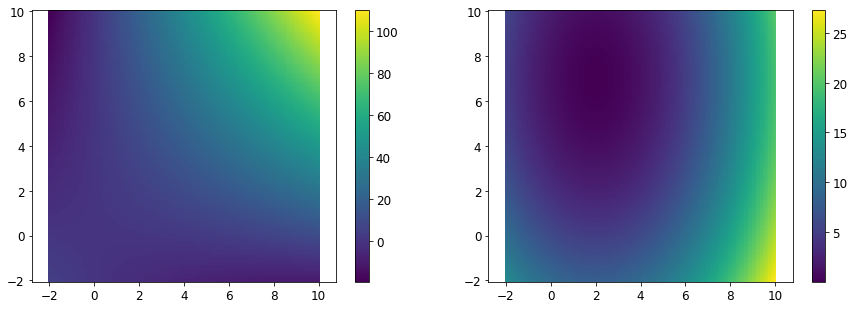

In [9]:
draw_3Dfunc_2out(func_0)

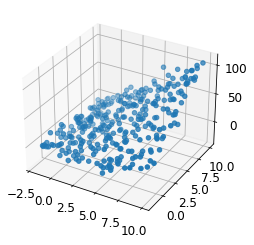

In [10]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train[:,0], X_train[:,1], y_train[:,0], marker='o')

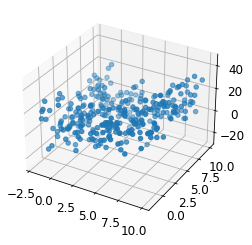

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train[:,0], X_train[:,1], y_train[:,1], marker='o')

In [12]:
# import plotly.express as px

# fig = px.scatter_3d(x=X_train[:,0], y=X_train[:,1], z=y_train[:,0])
# fig.show()

In [13]:
# fig = px.scatter_3d(x=X_train[:,0], y=X_train[:,1], z=y_train[:,1])
# fig.show()

In [14]:
prediction_error_dict = dict()
    
def get_prediction_error(func_in, func_ref, name="", x_min=-2, x_max=10, prediction_error_dict=prediction_error_dict):
    n_sample = 100
    x1v, x2v = np.meshgrid(np.linspace(x_min, x_max, n_sample), np.linspace(x_min, x_max, n_sample))
    mesh_shape = x1v.shape
    print("mesh_shape = %s" % str(mesh_shape))
    X1 = x1v.reshape([-1,1])
    X2 = x2v.reshape([-1,1])
    y_func = func_in(np.hstack((X1, X2)))
    y_gt  = func_ref(np.hstack((X1, X2)))
    print("y_func.shape = %s" % str(y_func.shape))
    print("y_gt.shape = %s" % str(y_gt.shape))
#     total_error = np.sqrt(np.square(y_func - y_gt).mean())
    total_error = np.abs(y_func - y_gt).mean(axis=0)
    prediction_error_dict[name] = total_error
    return total_error

def print_all_prediction_error(is_logging_to_screen=True, prediction_error_dict=prediction_error_dict):
    _s = ""
    for _n in prediction_error_dict:
        _s += ("%s: %s" % (_n, str(prediction_error_dict[_n]))) + "\n"
    if is_logging_to_screen:
        print(_s)
    return _s
        
def save_prediction_errors(is_logging_to_screen=False, prediction_error_dict=prediction_error_dict):
    path = os.path.join(IMAGES_PATH, "prediction_errors.txt")
    print("Saving all prediction errors to [%s]." % path)
    _s = print_all_prediction_error(is_logging_to_screen=is_logging_to_screen, prediction_error_dict=prediction_error_dict)
    with open(path, "w") as _f:
        _f.write(_s)
    return True

# Naive Model

In [15]:
model = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", input_shape=X_train.shape[1:]),
#     keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(2)
])

# optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9)
optimizer = keras.optimizers.Adam(lr=0.1)
model.compile(loss="mean_squared_error", optimizer=optimizer)

2022-04-19 14:52:27.863800: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-04-19 14:52:31.411705: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-19 14:52:31.411864: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (benson516-P1G2): /proc/driver/nvidia/version does not exist
2022-04-19 14:52:31.416616: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/benson516/GazeDemo/gaze_env/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument

In [16]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

2022-04-19 14:52:31.711062: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-19 14:52:31.729065: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2599990000 Hz


Epoch 1/100
10/10 [==============================] - 0s 12ms/step - loss: 309.5164 - val_loss: 185.4189
Epoch 2/100
10/10 [==============================] - 0s 3ms/step - loss: 143.8681 - val_loss: 150.7497
Epoch 3/100
10/10 [==============================] - 0s 3ms/step - loss: 130.9599 - val_loss: 142.0992
Epoch 4/100
10/10 [==============================] - 0s 6ms/step - loss: 129.9505 - val_loss: 129.4220
Epoch 5/100
10/10 [==============================] - 0s 6ms/step - loss: 112.9585 - val_loss: 127.7300
Epoch 6/100
10/10 [==============================] - 0s 5ms/step - loss: 112.3711 - val_loss: 128.3502
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 109.4267 - val_loss: 132.9748
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 111.1255 - val_loss: 120.4797
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 106.9458 - val_loss: 116.3720
Epoch 10/100
10/10 [==============================] - 0s 4ms/step - loss

10/10 [==============================] - 0s 5ms/step - loss: 101.5344 - val_loss: 111.7440
Epoch 81/100
10/10 [==============================] - 0s 4ms/step - loss: 92.5388 - val_loss: 109.9477
Epoch 82/100
10/10 [==============================] - 0s 5ms/step - loss: 92.6315 - val_loss: 107.8819
Epoch 83/100
10/10 [==============================] - 0s 4ms/step - loss: 90.2078 - val_loss: 125.3222
Epoch 84/100
10/10 [==============================] - 0s 4ms/step - loss: 95.0410 - val_loss: 120.6464
Epoch 85/100
10/10 [==============================] - 0s 4ms/step - loss: 94.2924 - val_loss: 107.7907
Epoch 86/100
10/10 [==============================] - 0s 4ms/step - loss: 94.0194 - val_loss: 109.9112
Epoch 87/100
10/10 [==============================] - 0s 4ms/step - loss: 94.0429 - val_loss: 107.6977
Epoch 88/100
10/10 [==============================] - 0s 5ms/step - loss: 89.7168 - val_loss: 121.7630
Epoch 89/100
10/10 [==============================] - 0s 3ms/step - loss: 92.2750 - v

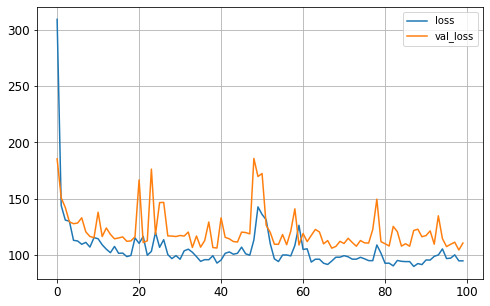

In [17]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
plt.show()

mesh_shape = (100, 100)
yv1.shape = (100, 100)
yv2.shape = (100, 100)


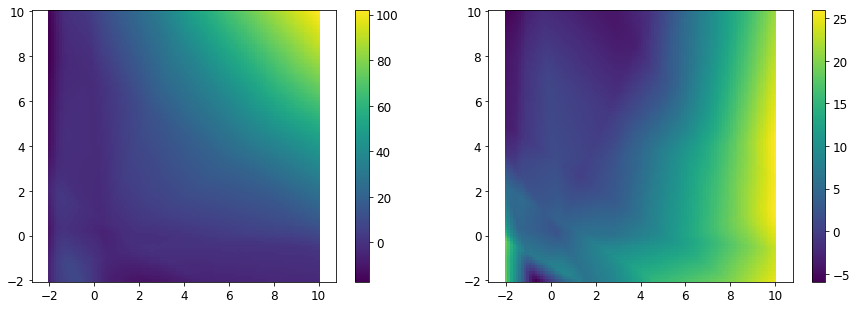

In [18]:
draw_3Dfunc_2out(model.predict)

mesh_shape = (100, 100)
y1.shape = (10000, 2)
y2.shape = (10000, 2)
yv1.shape = (100, 100)
yv2.shape = (100, 100)


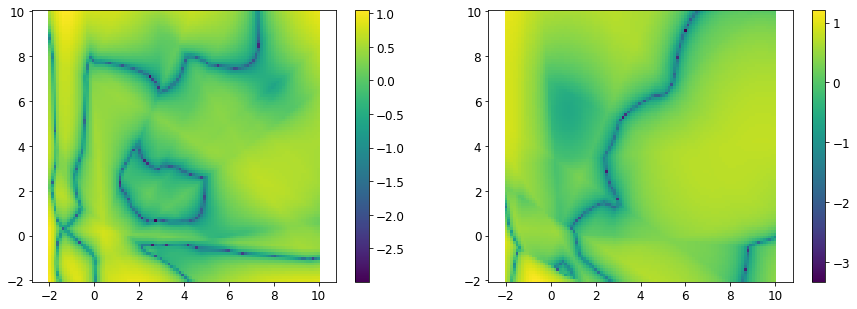

In [19]:
def log_abs_err_func(X):
    y1 = model.predict(X)
    y2 = func_0(X)
    print("y1.shape = %s" % str(y1.shape))
    print("y2.shape = %s" % str(y2.shape))
    return np.log(np.abs(y1 - y2)) / np.log(10.0)

draw_3Dfunc_2out(log_abs_err_func, vmin=None, vmax=None)

In [20]:
get_prediction_error(model.predict, func_0, name="num-num")

mesh_shape = (100, 100)
y_func.shape = (10000, 2)
y_gt.shape = (10000, 2)


array([1.98962372, 2.78017872])

# Simulated CNN Feature Map (1-D, grids)

In [21]:
class num2gridCh(keras.layers.Layer):
    def __init__(self, units, x_min=-10, x_max=10, sigma=1.0, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.x_min = x_min
        self.x_max = x_max
        self.sigma = sigma
        self.sigma2 = self.sigma**2
        self.activation = keras.activations.get(activation)
        
    def build(self, batch_input_shape):
        #
        self.x_grid = np.linspace(self.x_min, self.x_max, self.units, endpoint=True).reshape((-1,1))
#         print("self.x_grid.shape = %s" % str(self.x_grid.shape))
        #
        super().build(batch_input_shape) # must be at the end
        
    def call(self, X):
        '''
        Input shape:  (batch, X_chanel)
        Output shape: (batch, grid_unit, X_channel) <-- grid_unit is the dimension for conv1D to slide
        
        self.x_grid shape: (grid_unit,1)
        '''
        X_shape = X.shape
        X_span = tf.reshape(X, [-1,1,X_shape[-1]] )
        gauss_grid = tf.exp( -(self.x_grid - X_span)**2 / (2.0*self.sigma2) )
        return self.activation(gauss_grid)
    
    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units] + batch_input_shape.as_list()[-1:])
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 
                "units": self.units,
                "x_min": self.x_min,
                "x_max": self.x_max,
                "sigma": self.sigma,
                "activation": keras.activations.serialize(self.activation)}

Examine the shape

In [22]:
input_shape = (100, 2)
x = tf.random.normal(input_shape)
y = num2gridCh(50,x_min=-10, x_max=10, sigma=3.0, input_shape=input_shape[1:])(x)
y.shape

TensorShape([100, 50, 2])

Build the model

In [23]:
model = keras.models.Sequential([
    num2gridCh(5,x_min=-10, x_max=10, sigma=5.0, input_shape=X_train.shape[1:]),
    keras.layers.Flatten(),
#     keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(60, activation="relu"),
    keras.layers.Dense(2)
])

# optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9)
# model.compile(loss="mean_squared_error", optimizer=optimizer)
optimizer = keras.optimizers.Adam(lr=0.1)
model.compile(loss="mean_absolute_error", optimizer=optimizer)

/home/benson516/GazeDemo/gaze_env/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [24]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

Epoch 1/100
10/10 [==============================] - 0s 14ms/step - loss: 14.8997 - val_loss: 12.0830
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 10.6686 - val_loss: 10.7219
Epoch 3/100
10/10 [==============================] - 0s 3ms/step - loss: 8.7695 - val_loss: 8.9521
Epoch 4/100
10/10 [==============================] - 0s 6ms/step - loss: 8.3477 - val_loss: 8.5995
Epoch 5/100
10/10 [==============================] - 0s 6ms/step - loss: 8.1636 - val_loss: 8.8340
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 8.2643 - val_loss: 9.0412
Epoch 7/100
10/10 [==============================] - 0s 6ms/step - loss: 8.0094 - val_loss: 8.4600
Epoch 8/100
10/10 [==============================] - 0s 5ms/step - loss: 8.0394 - val_loss: 8.6061
Epoch 9/100
10/10 [==============================] - 0s 5ms/step - loss: 8.3164 - val_loss: 8.8101
Epoch 10/100
10/10 [==============================] - 0s 5ms/step - loss: 8.4210 - val_loss: 8.4434
Epoc

Epoch 83/100
10/10 [==============================] - 0s 3ms/step - loss: 7.6663 - val_loss: 8.8058
Epoch 84/100
10/10 [==============================] - 0s 3ms/step - loss: 7.9123 - val_loss: 9.1111
Epoch 85/100
10/10 [==============================] - 0s 4ms/step - loss: 8.2280 - val_loss: 8.4209
Epoch 86/100
10/10 [==============================] - 0s 3ms/step - loss: 7.9082 - val_loss: 8.6168
Epoch 87/100
10/10 [==============================] - 0s 4ms/step - loss: 7.6896 - val_loss: 8.7596
Epoch 88/100
10/10 [==============================] - 0s 2ms/step - loss: 7.9956 - val_loss: 8.9637
Epoch 89/100
10/10 [==============================] - 0s 3ms/step - loss: 8.0221 - val_loss: 8.6583
Epoch 90/100
10/10 [==============================] - 0s 3ms/step - loss: 7.6915 - val_loss: 8.3992
Epoch 91/100
10/10 [==============================] - 0s 4ms/step - loss: 7.6491 - val_loss: 8.5443
Epoch 92/100
10/10 [==============================] - 0s 4ms/step - loss: 7.5719 - val_loss: 8.3579


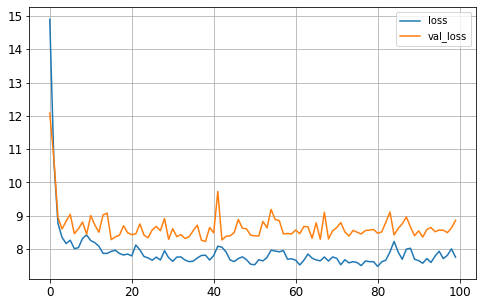

In [25]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
plt.show()

mesh_shape = (100, 100)
yv1.shape = (100, 100)
yv2.shape = (100, 100)


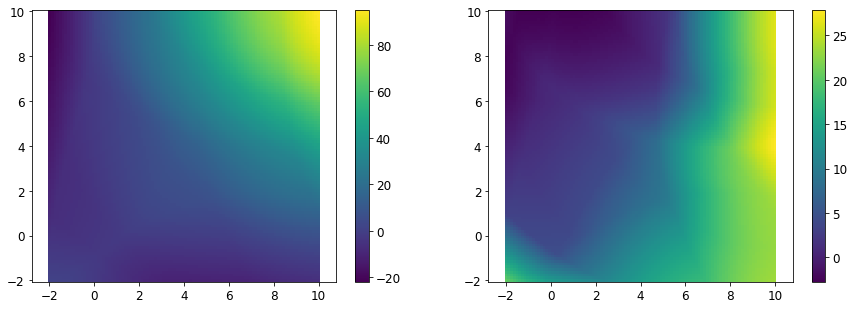

In [26]:
draw_3Dfunc_2out(model.predict)

mesh_shape = (100, 100)
y1.shape = (10000, 2)
y2.shape = (10000, 2)
yv1.shape = (100, 100)
yv2.shape = (100, 100)


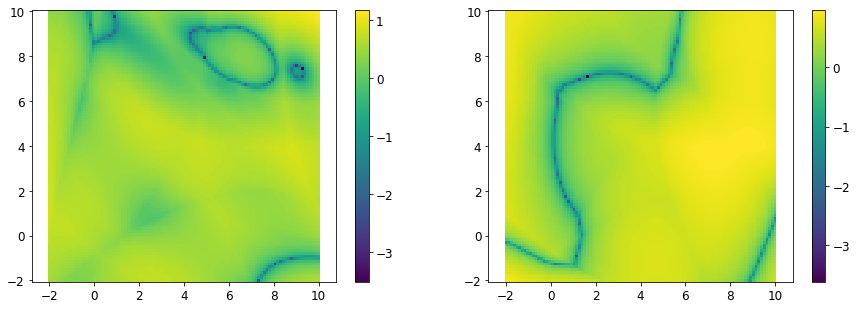

In [27]:
def log_abs_err_func(X):
    y1 = model.predict(X)
    y2 = func_0(X)
    print("y1.shape = %s" % str(y1.shape))
    print("y2.shape = %s" % str(y2.shape))
    return np.log(np.abs(y1 - y2)) / np.log(10.0)

draw_3Dfunc_2out(log_abs_err_func, vmin=None, vmax=None)

In [28]:
get_prediction_error(model.predict, func_0, name="grid-num")

mesh_shape = (100, 100)
y_func.shape = (10000, 2)
y_gt.shape = (10000, 2)


array([2.95983746, 3.71040943])

# Multi-Quantile Regression (Grid --> quantiles)

In [29]:
# Create a custom layer for converting the quantiles to original values
class quantiles2values(keras.layers.Layer):
    def __init__(self, num_value, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.num_value = num_value
        self.activation = keras.activations.get(activation)
        
    def build(self, batch_input_shape):
        super().build(batch_input_shape) # must be at the end
        
    def call(self, X):
        '''
        Input shape:  (batch, num_value*num_quantile)
        Output shape: (batch, num_value)
        '''
        X_shape = X.shape
        num_channel = X_shape[-1]
        num_quantile = num_channel // self.num_value
        y_list = [ tf.math.reduce_mean(X[:,_i:(_i + num_quantile)] , axis=-1, keepdims=True) 
                                   for _i in range(0, num_channel, num_quantile) ]
        y = tf.concat(y_list, 1)
        return self.activation(y)
    
    def compute_output_shape(self, batch_input_shape):
        _shape = batch_input_shape.as_list()
        return tf.TensorShape(_shape[:-1] + [self.num_value])
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 
                "num_value": self.num_value,
                "activation": keras.activations.serialize(self.activation)}

Set quantiles

In [30]:
# quantile_list = [0.5]
# quantile_list = [0.9]
# quantile_list = [0.1, 0.9] # Use hidden layer with 30 neurons
# quantile_list = [0.05, 0.95]
# quantile_list = [0.25, 0.75]
# quantile_list = [0.1, 0.5, 0.9]
# quantile_list = [0.1, 0.3, 0.7, 0.9]
# quantile_list = [0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9] # remove 0.5
quantile_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] # Should use wider hidden layer (with many neurons) + L1 regularization
num_quantile = len(quantile_list)

The number of output channels

In [31]:
num_output = 2

Build the models

In [32]:
# Build the model for training
model_q = keras.models.Sequential([
    num2gridCh(5,x_min=-10, x_max=10, sigma=5.0, input_shape=X_train.shape[1:]),
    keras.layers.Flatten(),
#     keras.layers.Dense(100, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    keras.layers.Dense(60, activation="relu"),
    keras.layers.Dense(num_output*num_quantile) # Note: 2 outputs --> 2 sets of quantiles
])

In [33]:
# Build the model for real use
model = keras.models.Sequential([
    model_q, 
    quantiles2values(num_output)
])

In [34]:
# Customized loss function
def pinballLoss_fn(y_true, y_pred, tau):
    # tau: quantile, tau in [0.0, 1.0]
    # y_true: label mean
    # y_pred: predicted tau quantile
    _q = y_true - y_pred
    return tf.math.maximum( (tau*_q), ((tau-1.0)*_q))
    
def pinballLoss_10_90_fn(y_true, y_pred):
    #
    return pinballLoss_fn(y_true, y_pred[:,0:1], 0.1) + pinballLoss_fn(y_true, y_pred[:,1:2], 0.9)

def pinballLoss_full_fn(y_true, y_pred):
    #
    pinball_losses = tf.concat( [pinballLoss_fn(y_true, y_pred[:, _i:(_i+1)], _tau) for _i, _tau in enumerate(quantile_list)], axis=-1)
    # print(pinball_losses.shape)
    return tf.reduce_sum(pinball_losses, axis=-1, keepdims=True)
    # S = tf.reduce_sum(pinball_losses, axis=-1, keepdims=True)
    # print(S.shape)
    # return S

def pinballLoss_full_multi_channels_fn(y_true, y_pred):
    # print(y_pred.shape)
    pinball_losses = tf.concat( [pinballLoss_full_fn(y_true[:,_i:(_i+1)], y_pred[:, (_i*num_quantile):(_i*num_quantile+num_quantile)]) for _i in range(y_true.shape[-1]) ], axis=-1)
    # print(pinball_losses.shape)
    return tf.reduce_sum(pinball_losses, axis=-1)
    

In [35]:
# Compile the model for training
optimizer = keras.optimizers.Adam(lr=0.1)
model_q.compile(loss=pinballLoss_full_multi_channels_fn, optimizer=optimizer)

# Compile the model for prediction
model.compile(loss="mean_absolute_error", optimizer=optimizer)

/home/benson516/GazeDemo/gaze_env/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [36]:
history = model_q.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

Epoch 1/100
10/10 [==============================] - 1s 19ms/step - loss: 126.3237 - val_loss: 102.2427
Epoch 2/100
10/10 [==============================] - 0s 3ms/step - loss: 92.1254 - val_loss: 75.4853
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 66.6241 - val_loss: 63.6418
Epoch 4/100
10/10 [==============================] - 0s 7ms/step - loss: 60.1082 - val_loss: 57.5851
Epoch 5/100
10/10 [==============================] - 0s 6ms/step - loss: 57.9002 - val_loss: 57.5147
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 56.8138 - val_loss: 59.1945
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 56.8694 - val_loss: 60.5867
Epoch 8/100
10/10 [==============================] - 0s 5ms/step - loss: 58.7338 - val_loss: 60.3236
Epoch 9/100
10/10 [==============================] - 0s 5ms/step - loss: 57.0443 - val_loss: 58.0219
Epoch 10/100
10/10 [==============================] - 0s 4ms/step - loss: 55.9409 - val_

10/10 [==============================] - 0s 6ms/step - loss: 52.9723 - val_loss: 58.9545
Epoch 82/100
10/10 [==============================] - 0s 7ms/step - loss: 53.8517 - val_loss: 61.8425
Epoch 83/100
10/10 [==============================] - 0s 7ms/step - loss: 54.6441 - val_loss: 58.4462
Epoch 84/100
10/10 [==============================] - 0s 7ms/step - loss: 53.1923 - val_loss: 57.4747
Epoch 85/100
10/10 [==============================] - 0s 7ms/step - loss: 53.1637 - val_loss: 58.3463
Epoch 86/100
10/10 [==============================] - 0s 7ms/step - loss: 53.7654 - val_loss: 57.7810
Epoch 87/100
10/10 [==============================] - 0s 6ms/step - loss: 54.5881 - val_loss: 62.9572
Epoch 88/100
10/10 [==============================] - 0s 6ms/step - loss: 53.7782 - val_loss: 57.0774
Epoch 89/100
10/10 [==============================] - 0s 6ms/step - loss: 53.0391 - val_loss: 58.1520
Epoch 90/100
10/10 [==============================] - 0s 7ms/step - loss: 53.8508 - val_loss: 5

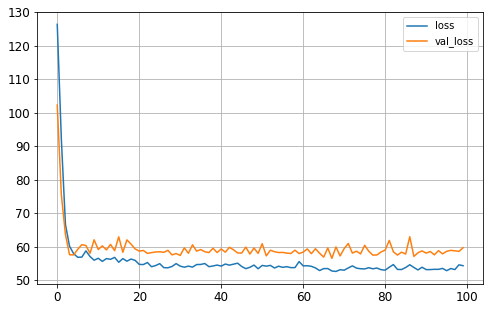

In [37]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
plt.show()

mesh_shape = (100, 100)
yv1.shape = (100, 100)
yv2.shape = (100, 100)


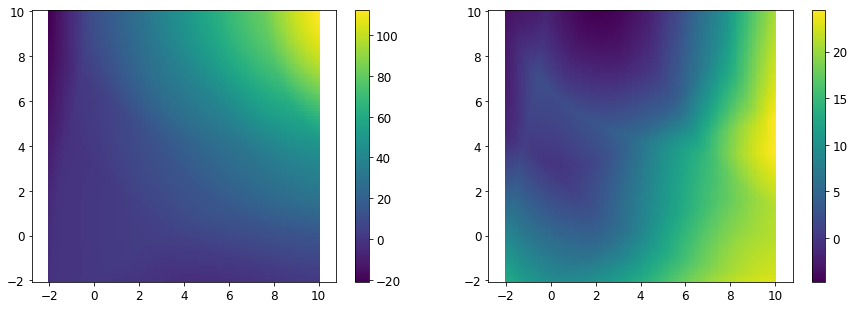

In [38]:
draw_3Dfunc_2out(model.predict)

mesh_shape = (100, 100)
y1.shape = (10000, 2)
y2.shape = (10000, 2)
yv1.shape = (100, 100)
yv2.shape = (100, 100)


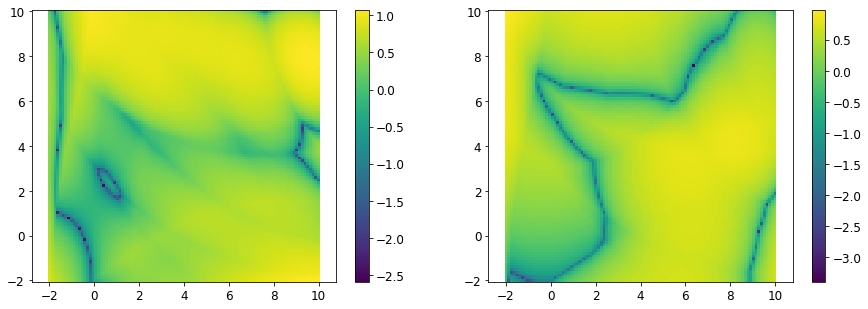

In [39]:
def log_abs_err_func(X):
    y1 = model.predict(X)
    y2 = func_0(X)
    print("y1.shape = %s" % str(y1.shape))
    print("y2.shape = %s" % str(y2.shape))
    return np.log(np.abs(y1 - y2)) / np.log(10.0)

draw_3Dfunc_2out(log_abs_err_func, vmin=None, vmax=None)

In [40]:
get_prediction_error(model.predict, func_0, name="grid-multiQuantileR")

mesh_shape = (100, 100)
y_func.shape = (10000, 2)
y_gt.shape = (10000, 2)


array([4.13696958, 2.79485887])

# Summary

In [41]:
results = print_all_prediction_error()

num-num: [1.98962372 2.78017872]
grid-num: [2.95983746 3.71040943]
grid-multiQuantileR: [4.13696958 2.79485887]



In [42]:
save_prediction_errors()

Saving all prediction errors to [./images/MIMO_regression/prediction_errors.txt].


True